# MODIS data summary
The data comes from UMD's ftp server: fuoco.geog.umd.edu

I'm getting the data from modis/C6/mcd14ml, is that right?

They have daily data from Nov 2000-Oct 2016. Currently I'm using Jan 2010-Oct 2016.

## Overall data summary
First, I will present some visualization from the data as a whole. Then, I will present some visualizations from an individual month.

In [1]:
# Imports. All standard except my read_raw_data function, which takes the raw data and converts
# it into an easily useable list of tuples of the form
import matplotlib.pyplot as plt
from carpentry.raw_to_dict import read_raw_data
from scipy.stats import pearsonr
from IPython import display
import numpy as np
import time
import os
import math

In [2]:
# Read in all our data. This cell takes a little while to run!
data_list_list = []
for finame in os.listdir('mcd14ml'):
    data_list_list.append(read_raw_data("mcd14ml/" + finame)[1:])
# data_list_list is a list of months, where each month is a list of tuples, one for each fire.
# Tuples are of the form (year, month, day, lat, long, FRP, confidence)
n_months = len(data_list_list)
print "Read from %d months" %(n_months)

Read from 82 months


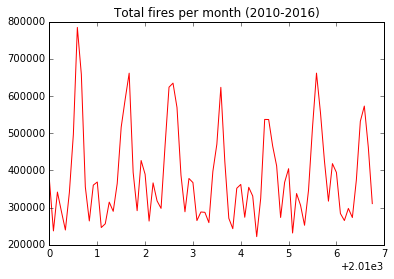

In [21]:
# Now let's plot some summary graphs. First, let's look at the total number of fires for each 
#  month
%matplotlib inline
total_fires_arr = np.zeros(n_months)
month_float_arr = np.zeros(n_months)
for i,dl in enumerate(data_list_list):
    year = dl[0][0]
    month = dl[0][1]
    month_float = year + (float(month-1) / 12.)
    total_fires = len(dl)
    month_float_arr[i] = month_float
    total_fires_arr[i] = total_fires
plt.plot(month_float_arr, total_fires_arr, 'r')
plt.title("Total fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()

Not too much of a trend, it seems. So let's plot by hemispheres to see if we see a trend

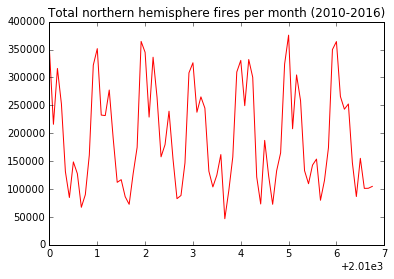

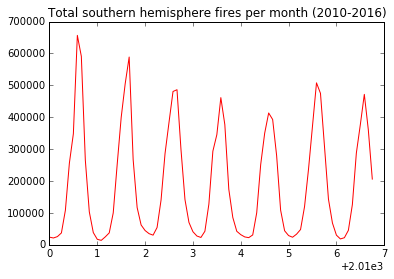

In [22]:
# The above graph but with a northern/southern hemisphere split
total_fires_north = np.zeros(n_months)
total_fires_south = np.zeros(n_months)
for i,dl in enumerate(data_list_list):
    year = dl[0][0]
    month = dl[0][1]
    month_float = year + (float(month-1) / 12.)
    north_fires = np.sum(np.array(map(lambda x: x[3] > 0, dl)))
    south_fires = np.sum(np.array(map(lambda x: x[3] < 0, dl)))
    total_fires_north[i] = north_fires
    total_fires_south[i] = south_fires
    
plt.plot(month_float_arr, total_fires_north, 'r')
plt.title("Total northern hemisphere fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()
plt.plot(month_float_arr, total_fires_south, 'r')
plt.title("Total southern hemisphere fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()

This seems to be the opposite of the trend I expected, each hemisphere has more fires in the winter than the summer! But then I realized that there might be two trends at work--summer is humid, which might lead to less fires, but also doesn't have snow. So I broke up the hemispheres into the "extreme" part (>40 degrees lat) and the "mild" part (<40 degrees). This gave us the trends we might expect

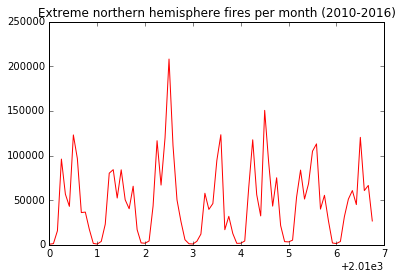

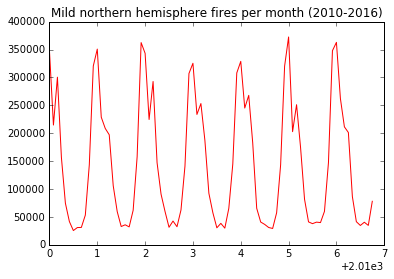

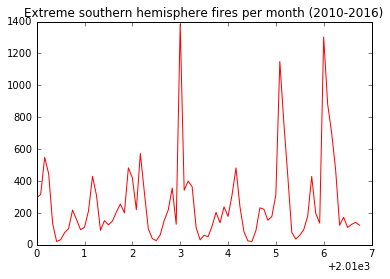

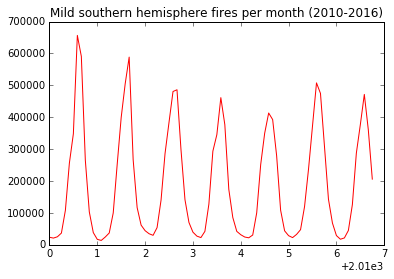

In [23]:
# Let's try the hemisphere plots but broken down by top part and bottom part of the hemisphere
extreme_north = np.zeros(n_months)
mild_north = np.zeros(n_months)
extreme_south = np.zeros(n_months)
mild_south = np.zeros(n_months)
for i,dl in enumerate(data_list_list):
    year = dl[0][0]
    month = dl[0][1]
    month_float = year + (float(month-1) / 12.)
    extreme_north_fires = np.sum(np.array(map(lambda x: x[3] > 40, dl)))
    mild_north_fires = np.sum(np.array(map(lambda x: 0 < x[3] < 40, dl)))
    extreme_south_fires = np.sum(np.array(map(lambda x: x[3] < -40, dl)))
    mild_south_fires = np.sum(np.array(map(lambda x: -40 < x[3] < 0, dl)))
    extreme_north[i] = extreme_north_fires
    mild_north[i] = mild_north_fires
    extreme_south[i] = extreme_south_fires
    mild_south[i] = mild_south_fires
    
plt.plot(month_float_arr, extreme_north, 'r')
plt.title("Extreme northern hemisphere fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()
plt.plot(month_float_arr, mild_north, 'r')
plt.title("Mild northern hemisphere fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()
plt.plot(month_float_arr, extreme_south, 'r')
plt.title("Extreme southern hemisphere fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()
plt.plot(month_float_arr, mild_south, 'r')
plt.title("Mild southern hemisphere fires per month (%d-%d)" %(int(math.floor(np.min(month_float_arr))), int(math.floor(np.max(month_float_arr)))))
plt.show()

[2011, 7, 1, 65.738, 167.726, 7.0, 0.6]


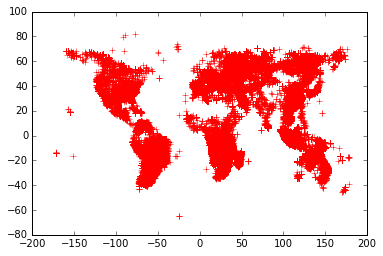

[2011, 1, 1, -6.247, 146.245, 8.2, 0.32]


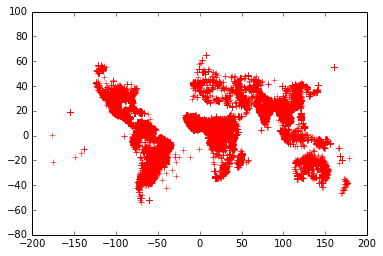

In [8]:
# Plot summer and winter in a single year
lat_summer = map(lambda x: x[3], data_list_list[18])   # latitude
long_summer = map(lambda x: x[4], data_list_list[18])  # longitude
print data_list_list[18][0]
plt.plot(long_summer, lat_summer, 'r+')
plt.ylim((-80, 100))
plt.xlim((-200, 200))
plt.show()

lat_winter = map(lambda x: x[3], data_list_list[12])   # latitude
long_winter = map(lambda x: x[4], data_list_list[12])  # longitude
print data_list_list[12][0]
plt.plot(long_winter, lat_winter, 'r+')
plt.ylim((-80, 100))
plt.xlim((-200, 200))
plt.show()

In [9]:
# Now, let's make make heatmaps for the world! One heatmap per month
lats = [-80, 100]   # latitude range
lons = [-200, 200]  # longitude range
gran = 2.           # how large grid cells will be
lat_grid = np.linspace(lats[0], lats[1], ((lats[1]-lats[0])/gran)+1)
lon_grid = np.linspace(lons[0], lons[1], ((lons[1]-lons[0])/gran)+1)
heatmap_tensor = np.zeros(((lons[1]-lons[0])/gran, (lats[1]-lats[0])/gran, 12))
for month in xrange(12):  # 0-indexed: month 0 is January
    for dl_ind in xrange(month, len(data_list_list), 12):
        for fire in data_list_list[dl_ind]:
            lat,lon = (fire[3], fire[4])
            lat_grid_pos = np.where(lat_grid > lat)[0][0] - 1
            lon_grid_pos = np.where(lon_grid > lon)[0][0] - 1
            heatmap_tensor[lon_grid_pos, lat_grid_pos, month] += 1

/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


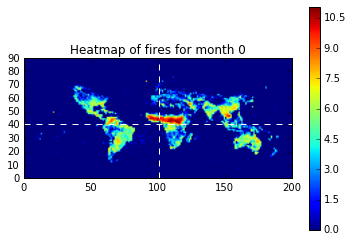

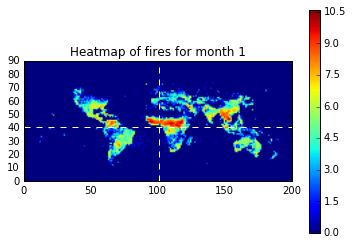

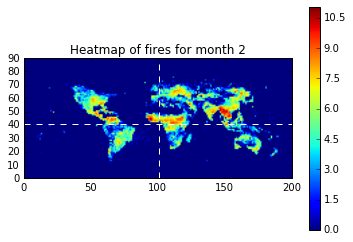

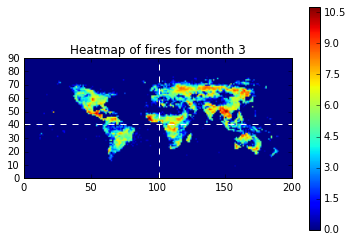

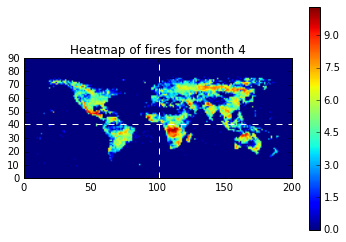

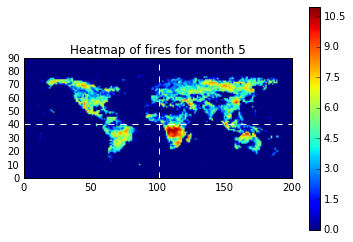

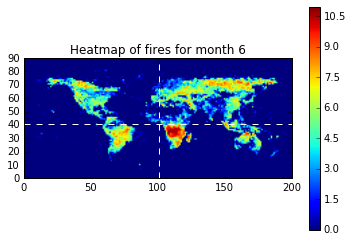

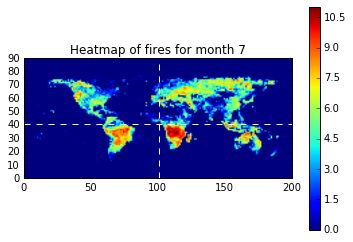

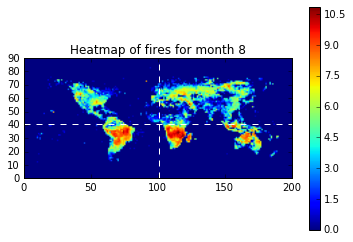

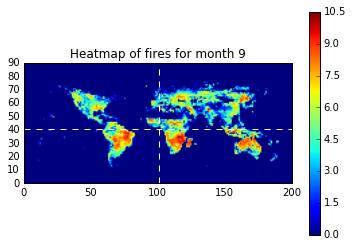

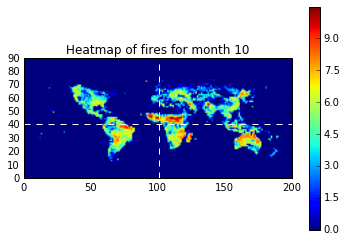

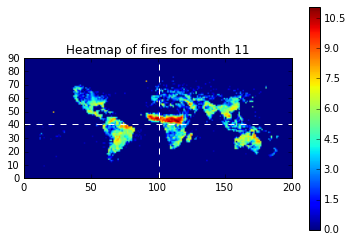

In [20]:
# Plot a heat map for each month of counts of fires. The linear heatmap showed that parts
# of Africa dominate the map, so I plot the log of the fire count in each grid square
zero_lat = np.where(lat_grid > 0)[0][0]
zero_lon = np.where(lon_grid > 0)[0][0]
for month in xrange(12):
    plt.imshow(np.transpose(np.log(heatmap_tensor[:,:,month]+1)))
    plt.colorbar()
    plt.title("Heatmap of fires for month %d" %month)
    plt.plot([zero_lon,zero_lon], [0,90], 'w--')
    plt.plot([0,200], [zero_lat,zero_lat], 'w--')
    plt.xlim((0,200))
    plt.ylim((0,90))
    plt.show()

## Looking at an individual month
I decided to dig a little deeper into a single month, for now, July of 2013. Since I wanted to look at Alaska specifically, it made sense to look at a July since that's when Alaska gets the most fires.

In [11]:
data_list = read_raw_data('mcd14ml/MCD14ML.201307.006.01.txt')  # July
data_list = data_list[1:]
print "read data file with %d data points" %len(data_list)

read data file with 470478 data points


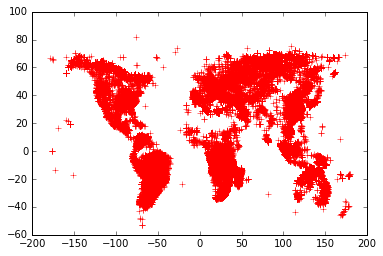

In [12]:
# First, let's plot the data overall
lat_arr = map(lambda x: x[3], data_list[1:])   # latitude
long_arr = map(lambda x: x[4], data_list[1:])  # longitude
plt.plot(long_arr, lat_arr, 'r+')
plt.show()

1560 fire pixels in alaksa bounding box


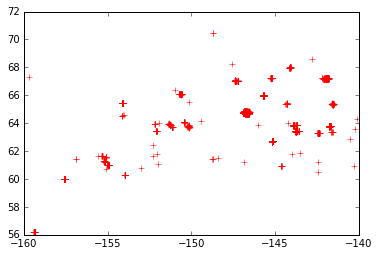

In [13]:
# Lots of fires! Let's check out just Alaska
ak_bb = [55, 72, -170, -140]  # min lat, max lat, min long, max long
alaska_lat = []
alaska_long = []
alaska_inds = []
alaska_days = []
for i,(lat,lon) in enumerate(zip(lat_arr, long_arr)):
    if (ak_bb[0] < lat < ak_bb[1]) and (ak_bb[2] < lon < ak_bb[3]):
        alaska_lat.append(lat)
        alaska_long.append(lon)
        alaska_days.append(data_list[i][2])
print "%d fire pixels in alaksa bounding box" %len(alaska_lat)
alaska_lat = np.array(alaska_lat)
alaska_long = np.array(alaska_long)
alaska_inds = np.array(alaska_inds)
alaska_days = np.array(alaska_days)
plt.plot(alaska_long, alaska_lat, 'r+')
plt.show()

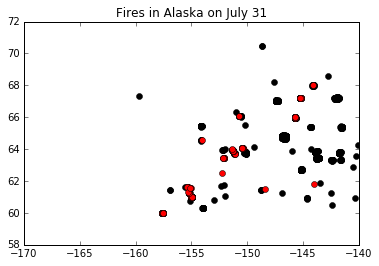

In [28]:
# Now, get the day for each fire, and plot the pixels by day
prev_inds = []
for day in xrange(1,32):
    day_inds = (alaska_days == day).nonzero()[0]
    display.clear_output(wait=True)
    if len(prev_inds):
        plt.plot(alaska_long[prev_inds], alaska_lat[prev_inds], 'ko')
    if len(day_inds):
        plt.plot(alaska_long[day_inds], alaska_lat[day_inds], 'ro')
    plt.title("Fires in Alaska on July %d" %day)
    plt.ylim((58,72))
    plt.xlim((-170, -140))
    plt.show()
    time.sleep(2)
    prev_inds += list(day_inds)


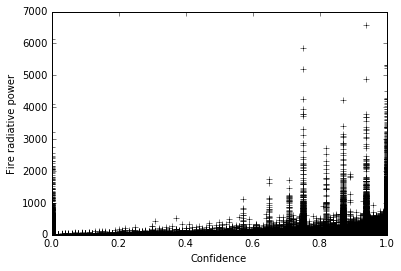

Pearson correlation: 0.2712, pvalue 0.0000


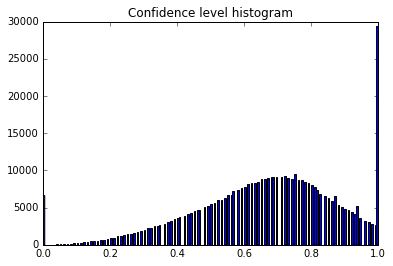

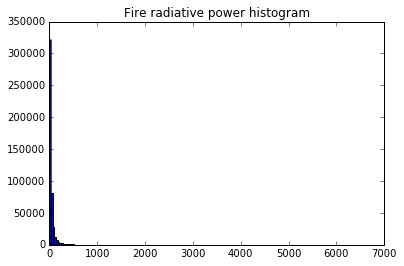

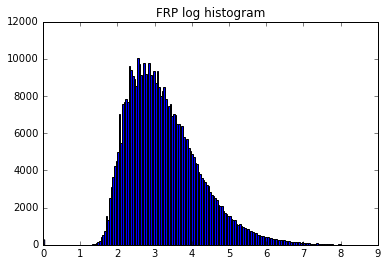

In [15]:
# Let's look at FRP and cofidence, are they correlated?
conf = map(lambda x: x[-1], data_list)
frp = map(lambda x: x[-2], data_list)
plt.plot(conf, frp, 'k+')
plt.ylabel('Fire radiative power')
plt.xlabel('Confidence')
plt.show()

corr = pearsonr(conf,frp)
print "Pearson correlation: %.4f, pvalue %.4f" %(corr[0],corr[1])

# Histograms of each
plt.hist(conf, bins=200)
plt.title('Confidence level histogram')
plt.show()

plt.hist(frp, bins=200)
plt.title('Fire radiative power histogram')
plt.show()

plt.hist(np.log(np.array(frp)+1), bins=200)
plt.title("FRP log histogram")
plt.show()

In [29]:
# Let's dump the data_list_list to pickle to load later
import cPickle
cPickle.dump(data_list_list, open("data_list_list.pkl","w"))